In [48]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
def readTrain():
  # train = pd.read_csv("SPY.csv")
  # train = pd.read_csv('2330.TW.csv')
  train = pd.read_csv('2023資料探勘 - 工作表20.csv')

  return train

In [50]:
def augFeatures(train):
  train["Date"] = pd.to_datetime(train["Date"])
  train["year"] = train["Date"].dt.year
  train["month"] = train["Date"].dt.month
  train["date"] = train["Date"].dt.day
  train["day"] = train["Date"].dt.dayofweek
  return train

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

# sc = MinMaxScaler (feature_range = (0, 1))
sc = MaxAbsScaler ()


def normalize(train):
  train = train.drop(["Date"], axis=1)
  # train = train.drop(['Volume'],axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm

def normalize2(train):
  # train = train.drop(["Date"], axis=1)
  training_set_scaled = sc.fit_transform(train)

  return training_set_scaled
# def denormlized(norm,dmax,dmin,dmean):
#   denorm = norm.apply(lambda x :  x*(dmax-dmin)+dmean)
# return denorm

In [52]:
def buildTrain(train, pastDay=30, futureDay=5):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Adj Close"]))
  return np.array(X_train), np.array(Y_train)

In [53]:
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [54]:
def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [55]:
# for ele in train_Aug:
#     if(ele == 'Date'):
#         continue
#     print(ele,type(train_Aug[ele][1]))
#     train_Aug[ele] = train_Aug[ele].astype(float)



In [56]:
# read SPY.csv
train = readTrain()

# Augment the features (year, month, date, day)
train_Aug = augFeatures(train)

# Normalization
train_norm = normalize(train_Aug)
# train_norm = train_Aug

# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(train_norm[:-30], 1, 1)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
# X_trian: (5710, 30, 10)
# Y_train: (5710, 5, 1)
# X_val: (634, 30, 10)
# Y_val: (634, 5, 1)

In [57]:
def buildOneToOneModel(shape):
  model = Sequential()

  model.add(GRU(20, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  model.add(GRU(20, input_length=shape[1], input_dim=shape[2],return_sequences=True))

  # model.add(BatchNormalization( ))

            


  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model


In [68]:
def builddnnModel(shape):
    model= Sequential()
    model.add(LSTM(256, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    #接著架構輸入層，輸入的維度為1Ｘ3072
    # model.add(Dense(units=256, 
    #                 input_dim=shape[2],
    #                 kernel_initializer='normal', 
    #                 activation='relu'))
    # #接著架構隱藏層，這邊架構兩層就好了，寬度為256個 units
    # model.add(Dense(units=256, 
    #                 kernel_initializer='normal', 
    #                 activation='relu'))
    # model.add(Dense(units=256, 
    #                 kernel_initializer='normal', 
    #                 activation='relu'))
    #最後架構輸出層，因為 cifar10 的 label 總共為10總，所以輸出層的大小設定為10個 units
    # model.add(Dense(units=1, 
    #                 kernel_initializer='normal', 
    #                 activation='softmax'))

    model.add(TimeDistributed(Dense(1))) 
    # model.add((Dense(1))) 
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [69]:

train_tmp = train_Aug.copy()
max(train_Aug['Open'])
min(train_Aug['Open'])

# # x = z(max - min) + min

bigtrain = dict()
smalltrain = dict()
meantrain = dict()

for ele in train_Aug:
    if(ele == 'Date'):
        continue

    bigtrain[ele] = max(train_Aug[ele])
    smalltrain[ele]= min(train_Aug[ele])
    meantrain[ele] = np.mean(train_Aug[ele])

for ele in train_Aug:
    if(ele == 'Date'):
        continue
 


    train_tmp[ele] = train_norm[ele]*(bigtrain[ele] -smalltrain[ele]  )+meantrain[ele]

def denormClose(x):
    return x*(bigtrain['Adj Close'] -smalltrain['Adj Close']  )+ meantrain['Adj Close']

train_tmp

# train_Aug

,Date,費城半導體,Open,High,Low,Adj Close,漲跌,漲跌\n(%),振幅\n(%),Volume,...,融券(張)增減,融券(張)餘額,券資\n比\n(%),美商高盛-買進張數,美林-買進張數,新加玻商瑞銀-買進張數,year,month,date,day
0,1.653264e+18,2898.43,533.0,534.0,528.0,528.0,-2.0,-0.38,1.13,18919.0,...,-3.0,353.0,1.06,138.0,942.0,1062.7,2022.0,5.0,23.0,0.0
1,1.653350e+18,2827.05,530.0,531.0,520.0,520.0,-8.0,-1.52,2.08,19131.0,...,-29.0,324.0,0.98,880.6,609.0,676.0,2022.0,5.0,24.0,1.0
2,1.653437e+18,2882.93,522.0,529.0,520.0,524.0,4.0,0.77,1.73,22460.0,...,-33.0,291.0,0.87,1593.0,1973.9,584.2,2022.0,5.0,25.0,2.0
3,1.653523e+18,2994.61,523.0,525.0,513.0,514.0,-10.0,-1.91,2.29,31543.0,...,-22.0,269.0,0.80,724.0,1042.0,663.0,2022.0,5.0,26.0,3.0
4,1.653610e+18,3115.35,524.0,530.0,522.0,530.0,16.0,3.11,1.56,30113.0,...,25.0,294.0,0.89,3529.3,2288.0,1065.6,2022.0,5.0,27.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,1.684109e+18,3052.64,497.0,499.5,494.5,495.5,-0.5,-0.10,1.01,15548.0,...,20.0,491.0,2.86,888.7,700.0,193.0,2023.0,5.0,15.0,0.0
229,1.684195e+18,3048.71,503.0,508.0,500.0,505.0,9.5,1.92,1.61,24053.0,...,61.0,552.0,3.26,1015.4,742.0,1700.2,2023.0,5.0,16.0,1.0
230,1.684282e+18,3124.68,508.0,521.0,506.0,519.0,14.0,2.77,2.97,44352.0,...,240.0,792.0,4.93,6683.7,3049.2,1403.0,2023.0,5.0,17.0,2.0
231,1.684368e+18,3223.49,533.0,536.0,526.0,530.0,11.0,2.12,1.93,46108.0,...,74.0,866.0,5.60,3394.5,1373.0,1805.0,2023.0,5.0,18.0,3.0


In [114]:
def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [115]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

model = buildOneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 10)             1600      
                                                                 
 time_distributed_22 (TimeDi  (None, 1, 1)             11        
 stributed)                                                      
                                                                 
Total params: 1,611
Trainable params: 1,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 2s 465ms/step - loss: 0.0373 - val_loss: 0.0519
Epoch 2/1000
2/2 [==============================] - 0s 70ms/step - loss: 0.0357 - val_loss: 0.0499
Epoch 3/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.0343 - val_loss: 0.0479
Epoch 4/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.0329 - v

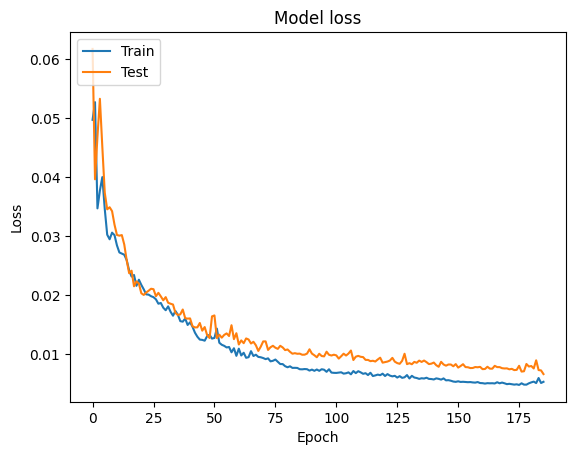

1/1 [==============================] - 0s 353ms/step


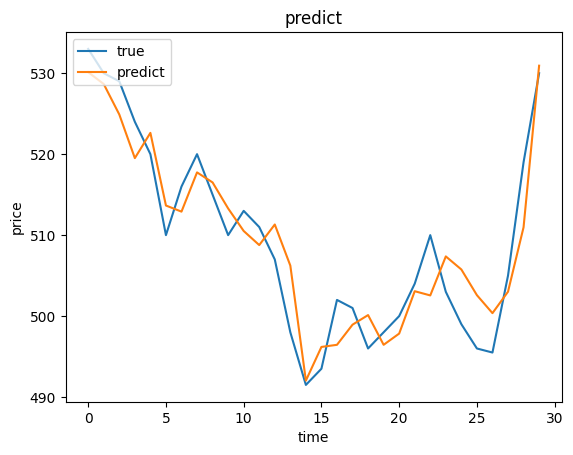

30

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

fuckx,fucky = buildTrain(train_norm, 1, 1)

# model.predict([1,2,3,4,5,6,7,8,9,10])
# X_train[]

# print(denormClose(Y_train[:]) )
# denormClose( model.predict( X_train[:]) ).flatten()


plt.plot(denormClose(fucky[-30:]).flatten() )
plt.plot(denormClose(model.predict( fuckx[-30:])).flatten())
# plt.plot(denormClose(model.predict( fuckx[-30:])[:,4]).flatten())

plt.title('predict')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['true', 'predict'], loc='upper left')
plt.show()
len(denormClose(fucky[-30:]).flatten())


In [86]:
def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(512, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # model.add(GRU(512, input_length=shape[1], input_dim=shape[2]))

    #接著架構輸入層，輸入的維度為1Ｘ3072
  model.add(Dense(units=512, 
                    input_dim=shape[2],
                    kernel_initializer='normal', 
                    activation='relu'))
    #接著架構隱藏層，這邊架構兩層就好了，寬度為256個 units
  model.add(Dense(units=256, 
                    kernel_initializer='normal', 
                    activation='relu'))
  model.add(Dense(units=256, 
                    kernel_initializer='normal', 
                    activation='relu'))
  model.add(GRU(128, input_length=shape[1], input_dim=shape[2]))
  
    # 最後架構輸出層，因為 cifar10 的 label 總共為10總，所以輸出層的大小設定為10個 units
  # model.add(Dense(units=1, 
  #                   kernel_initializer='normal', 
  #                   activation='softmax'))
  # output shape: (1, 1)
  model.add(Dense(1))
  # model.add(TimeDistributed(Dense(1)))

  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [92]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm[:-30], 5, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 512)            1110016   
                                                                 
 dense_61 (Dense)            (None, 5, 512)            262656    
                                                                 
 dense_62 (Dense)            (None, 5, 256)            131328    
                                                                 
 dense_63 (Dense)            (None, 5, 256)            65792     
                                                                 
 gru_37 (GRU)                (None, 128)               148224    
                                                                 
 dense_64 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,718,145
Trainable params: 1,718,145
N

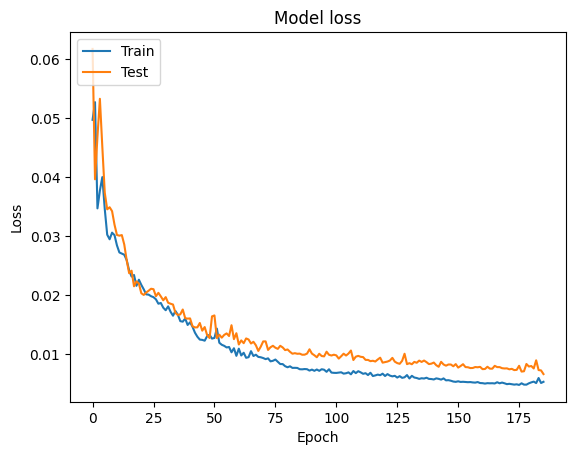

1/1 [==============================] - 0s 40ms/step


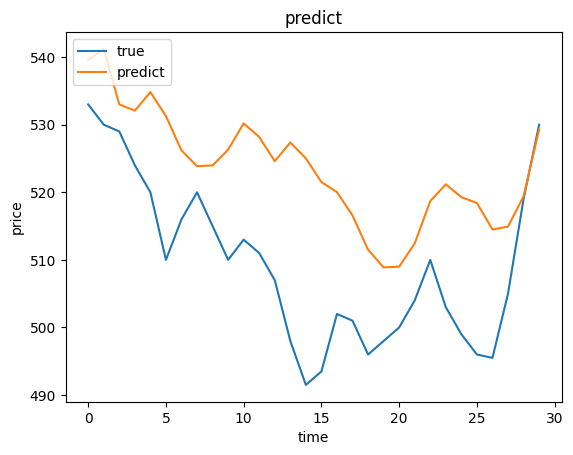

30

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

fuckx,fucky = buildTrain(train_norm, 5, 1)

# model.predict([1,2,3,4,5,6,7,8,9,10])
# X_train[]

# print(denormClose(Y_train[:]) )
# denormClose( model.predict( X_train[:]) ).flatten()


plt.plot(denormClose(fucky[-30:]).flatten() )
plt.plot(denormClose(model.predict( fuckx[-30:])).flatten())
# plt.plot(denormClose(model.predict( fuckx[-30:])[:,4]).flatten())

plt.title('predict')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['true', 'predict'], loc='upper left')
plt.show()
len(denormClose(fucky[-30:]).flatten())


In [111]:
def buildOneToManyModel(shape):
  model = Sequential()
  model.add(GRU(20, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  model.add(GRU(20))
  

  # output shape: (5, 1)
  model.add(Dense(1))
  model.add(RepeatVector(5))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [112]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm[:-30], 5, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildOneToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_50 (GRU)                (None, 5, 20)             3060      
                                                                 
 gru_51 (GRU)                (None, 20)                2520      
                                                                 
 dense_71 (Dense)            (None, 1)                 21        
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 1)             0         
 or)                                                             
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 3s 595ms/step - loss: 0.0328 - val_loss: 0.0431
Epoch 2/1000
2/2 

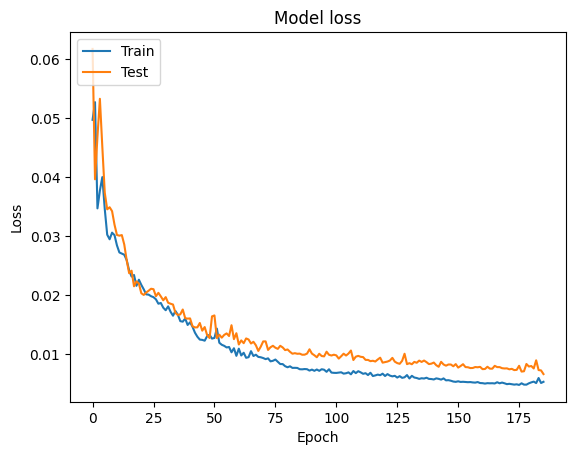

1/1 [==============================] - 1s 561ms/step


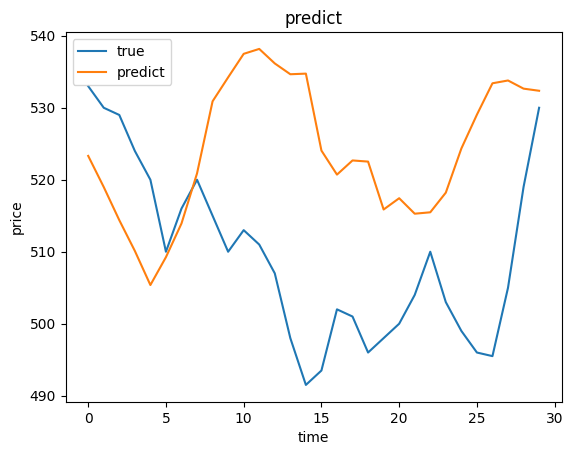

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

fuckx,fucky = buildTrain(train_norm, 5, 5)

# model.predict([1,2,3,4,5,6,7,8,9,10])
# X_train[]

# print(denormClose(Y_train[:]) )
# denormClose( model.predict( X_train[:]) ).flatten()

plt.plot(denormClose(fucky[-30:][:,4]).flatten() )
plt.plot(denormClose(model.predict( fuckx[-30:])[:,4]).flatten())
plt.title('predict')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['true', 'predict'], loc='upper left')
plt.show()


In [108]:
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(GRU(20, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  model.add(GRU(20, input_length=shape[1], input_dim=shape[2],return_sequences=True))

  # output shape: (5, 1)
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [109]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm[:-30], 5, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_48 (GRU)                (None, 30, 20)            3060      
                                                                 
 gru_49 (GRU)                (None, 30, 20)            2520      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 1)            21        
 stributed)                                                      
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


ValueError: in user code:

    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 1470, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 30 and 5 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_37/time_distributed_21/Reshape_1, IteratorGetNext:1)' with input shapes: [?,30,1], [?,5,1].


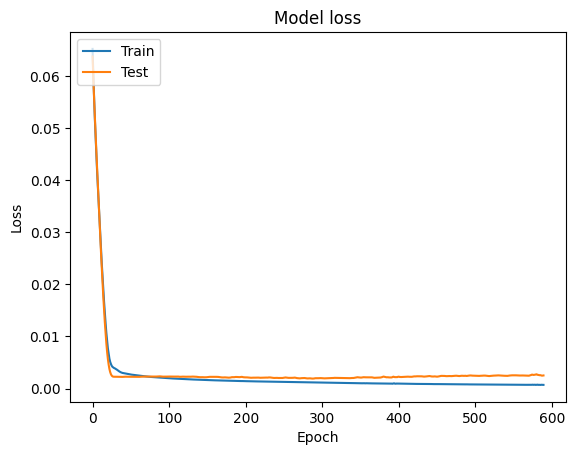

1/1 [==============================] - 1s 545ms/step


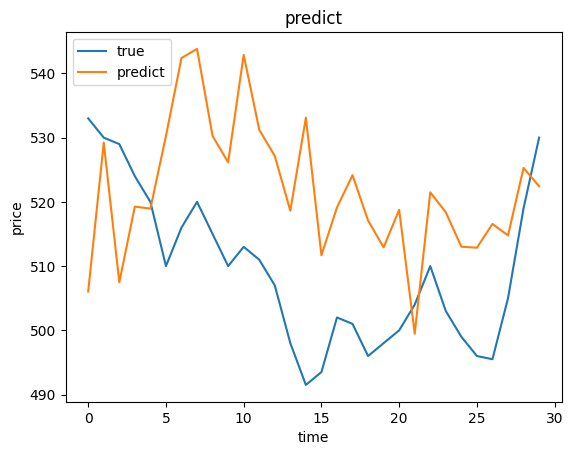

In [591]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

fuckx,fucky = buildTrain(train_norm, 5, 5)

# model.predict([1,2,3,4,5,6,7,8,9,10])
# X_train[]

# print(denormClose(Y_train[:]) )
# denormClose( model.predict( X_train[:]) ).flatten()


plt.plot(denormClose(fucky[-30:][:,4]).flatten() )
plt.plot(denormClose(model.predict( fuckx[-30:])[:,4]).flatten())
plt.title('predict')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['true', 'predict'], loc='upper left')
plt.show()



In [105]:
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(GRU(20, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # model.add(BatchNormalization())

  model.add(GRU(20, input_length=shape[1], input_dim=shape[2], return_sequences=True))

  # model.add(GRU(20, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # model.add(BatchNormalization())
  # model.add(GRU(20, input_length=shape[1], input_dim=shape[2], return_sequences=True))

  # model.add(GRU(20, input_length=shape[1], input_dim=shape[2], return_sequences=True))

  # output shape: (5, 1)
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [106]:
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm[:-30], 5, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_44 (GRU)                (None, 30, 20)            3060      
                                                                 
 gru_45 (GRU)                (None, 30, 20)            2520      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 1)            21        
 stributed)                                                      
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


ValueError: in user code:

    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 1470, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 30 and 5 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_35/time_distributed_19/Reshape_1, IteratorGetNext:1)' with input shapes: [?,30,1], [?,5,1].


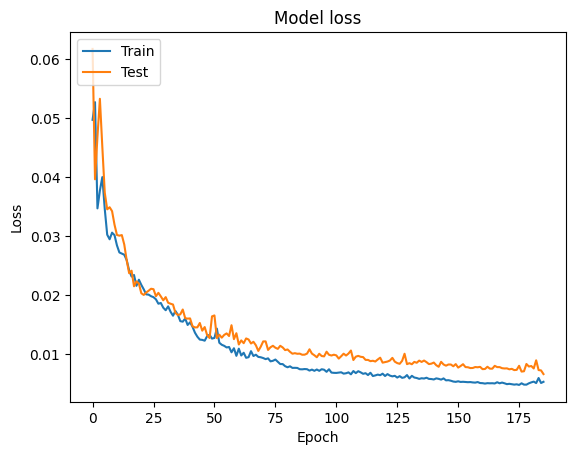

1/1 [==============================] - 1s 577ms/step


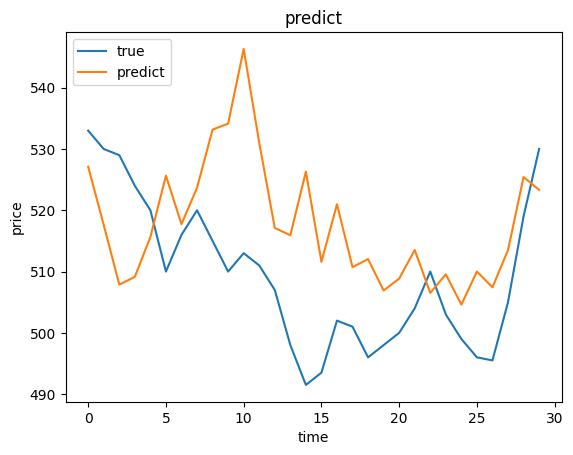

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

fuckx,fucky = buildTrain(train_norm, 5, 5)

# model.predict([1,2,3,4,5,6,7,8,9,10])
# X_train[]

# print(denormClose(Y_train[:]) )
# denormClose( model.predict( X_train[:]) ).flatten()


plt.plot(denormClose(fucky[-30:][:,4]).flatten() )
plt.plot(denormClose(model.predict( fuckx[-30:])[:,4]).flatten())
plt.title('predict')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['true', 'predict'], loc='upper left')
plt.show()